In [ ]:
# 1. SETUP

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 200)

# --- File paths ---
TRAIN_PATH = "/content/train_file.csv"
TEST_PATH  = "/content/test_file.csv"
SUB_PATH   = "/content/sample_submission.csv"

# --- Load data ---
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

print("Shapes -> train, test, sample_submission:", train.shape, test.shape, sub.shape)
print("Train columns:", list(train.columns))
print("\nTarget summary (Item_Outlet_Sales):")
print(train["Item_Outlet_Sales"].describe())

Shapes -> train, test, sample_submission: (8523, 12) (5681, 11) (5681, 3)
Train columns: ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']

Target summary (Item_Outlet_Sales):
count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64


In [ ]:
# 2. COMBINE DATA

train["source"] = "train"
test["source"]  = "test"
data = pd.concat([train, test], ignore_index=True)
print("Combined data shape:", data.shape)

Combined data shape: (14204, 13)


In [ ]:
# 3. CLEANING

# Impute Item_Weight by mean of Item_Identifier
weight_mean = data.pivot_table(values="Item_Weight", index="Item_Identifier", aggfunc="mean")
mask_w = data["Item_Weight"].isna()
data.loc[mask_w, "Item_Weight"] = data.loc[mask_w, "Item_Identifier"].map(weight_mean["Item_Weight"])

# Impute Outlet_Size by mode per Outlet_Type
mode_by_type = data.groupby("Outlet_Type")["Outlet_Size"].agg(lambda x: x.mode().iloc[0])
mask_s = data["Outlet_Size"].isna()
data.loc[mask_s, "Outlet_Size"] = data.loc[mask_s, "Outlet_Type"].map(mode_by_type)

# Replace Item_Visibility == 0 with mean per product
vis_mean = data.pivot_table(values="Item_Visibility", index="Item_Identifier", aggfunc="mean")["Item_Visibility"]
mask_v = data["Item_Visibility"].eq(0)
data.loc[mask_v, "Item_Visibility"] = data.loc[mask_v, "Item_Identifier"].map(vis_mean)

print("Missing after cleaning:\n", data.isna().sum().sort_values(ascending=False).head(10))

Missing after cleaning:
 Item_Outlet_Sales            5681
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Identifier                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Size                     0
dtype: int64


In [ ]:
# 4. FEATURE ENGINEERING

# A) Visibility mean ratio
data["_vis_mean"] = data["Item_Identifier"].map(vis_mean)
data["Item_Visibility_MeanRatio"] = data["Item_Visibility"] / data["_vis_mean"]
data.drop(columns=["_vis_mean"], inplace=True)

# B) Item_Type_Combined (FD/DR/NC)
data["Item_Type_Combined"] = data["Item_Identifier"].str[:2].map(
    {"FD": "Food", "DR": "Drinks", "NC": "Non-Consumable"}
)

# C) Outlet_Years
data["Outlet_Years"] = 2013 - data["Outlet_Establishment_Year"]

# D) Fix Item_Fat_Content and add Non-Edible
data["Item_Fat_Content"] = data["Item_Fat_Content"].replace(
    {"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"}
)
data.loc[data["Item_Type_Combined"].eq("Non-Consumable"), "Item_Fat_Content"] = "Non-Edible"

# E) One-Hot encode
cat_cols = [
    "Item_Fat_Content",
    "Outlet_Location_Type",
    "Outlet_Size",
    "Outlet_Type",
    "Item_Type_Combined",
    "Outlet_Identifier"
]
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=False)
print("Encoded shape:", data_encoded.shape)

Encoded shape: (14204, 36)


In [ ]:
# 5. SPLIT BACK TO TRAIN / TEST

train_mask = data_encoded["source"].eq("train")
test_mask  = data_encoded["source"].eq("test")

drop_cols = ["Item_Type", "Outlet_Establishment_Year", "source"]
train_mod = data_encoded.loc[train_mask].drop(columns=drop_cols, errors="ignore")
test_mod  = data_encoded.loc[test_mask].drop(columns=drop_cols + ["Item_Outlet_Sales"], errors="ignore")

target = "Item_Outlet_Sales"
X = train_mod.drop(columns=[target], errors="ignore")
y = train_mod[target].values
X_test = test_mod[X.columns]
print("Shapes -> X, y, X_test:", X.shape, y.shape, X_test.shape)

Shapes -> X, y, X_test: (8523, 32) (8523,) (5681, 32)


In [ ]:
# 6. CROSS-VALIDATION FUNCTION

# HOTFIX — ensure X/X_test are numeric only (drop text ids like Item_Identifier)

# List any remaining object (string) columns in X
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Object columns in X to drop:", obj_cols)

# Always drop Item_Identifier from modeling (id, high-cardinality, non-informative)
cols_to_drop_from_features = set(obj_cols) | {"Item_Identifier"}

# Drop from X and X_test, then re-align columns
X = X.drop(columns=list(cols_to_drop_from_features), errors="ignore")
X_test = X_test.drop(columns=list(cols_to_drop_from_features), errors="ignore")

# Safety: ensure identical column order
X_test = X_test[X.columns]

print("Shapes after dropping object cols -> X, X_test:", X.shape, X_test.shape)
print("Any object dtypes left in X?", X.select_dtypes(include=["object"]).shape[1] > 0)

def cv_rmse(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1)
    rmse = np.sqrt(-scores)
    return rmse.mean(), rmse.std(), rmse.min(), rmse.max()

Object columns in X to drop: ['Item_Identifier']
Shapes after dropping object cols -> X, X_test: (8523, 31) (5681, 31)
Any object dtypes left in X? False


In [ ]:
# 7. BASELINE

mean_sales = y.mean()
baseline_rmse = np.sqrt(mean_squared_error(y, np.full_like(y, mean_sales)))
print(f"Baseline RMSE: {baseline_rmse:.2f}")

Baseline RMSE: 1706.40


Linear RMSE mean=1129.6 std=37.4 min=1067.2 max=1170.1
Ridge RMSE mean=1129.6 std=37.4 min=1067.2 max=1170.1


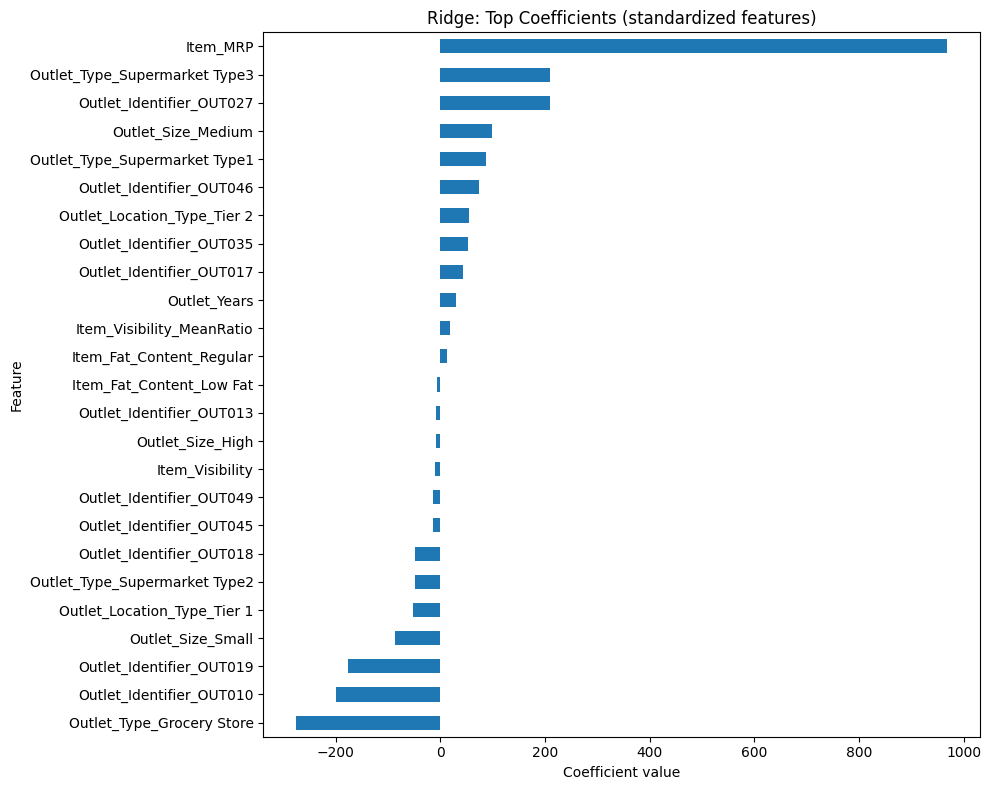

In [ ]:
# 8. LINEAR + RIDGE REGRESSION

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=0.05, random_state=RANDOM_STATE)
}
for name, model in models.items():
    m, s, mn, mx = cv_rmse(model, X, y)
    print(f"{name} RMSE mean={m:.1f} std={s:.1f} min={mn:.1f} max={mx:.1f}")

# COEFFICIENTS CHART — RIDGE (STANDARDIZED)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Standardize features so coefficients are comparable (no mean-centering for sparse-like one-hots)
ridge_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Ridge(alpha=0.05, random_state=RANDOM_STATE))
])

ridge_pipe.fit(X, y)
ridge_coef = pd.Series(
    ridge_pipe.named_steps["model"].coef_,
    index=X.columns
)

# Plot top |coef| features
top_k = 25
coef_top = ridge_coef.reindex(ridge_coef.abs().sort_values(ascending=False).head(top_k).index)

plt.figure(figsize=(10, 8))
coef_top.sort_values().plot(kind="barh")
plt.title("Ridge: Top Coefficients (standardized features)")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


DT depth=15 RMSE mean=1096.7 std=34.0 min=1036.1 max=1133.2
DT depth=8 RMSE mean=1097.9 std=38.7 min=1029.0 max=1135.1
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best DecisionTree params: {'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 2}
Best DecisionTree CV RMSE: 1093.8254


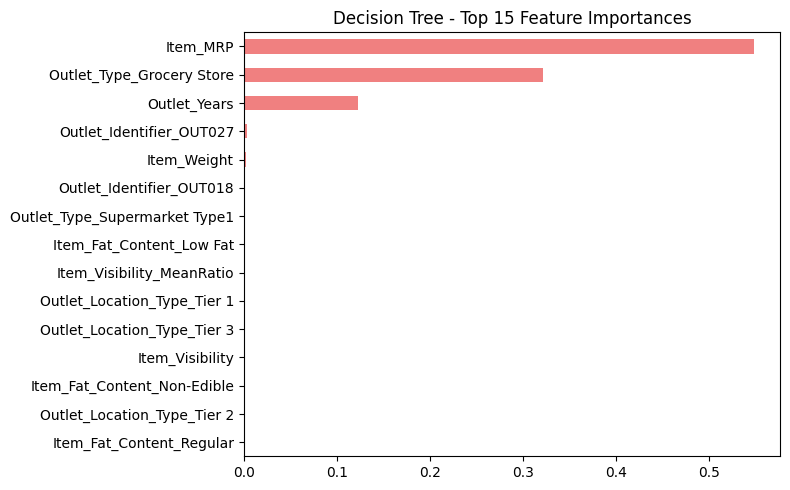

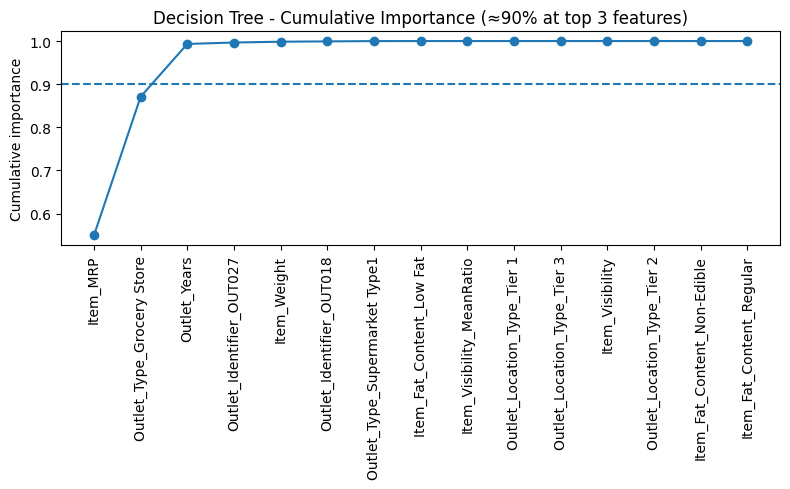

In [ ]:
# 9. DECISION TREE — tuned + cumulative importance

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# (A) Quick baselines (same as before)
dt_models = {
    "DT depth=15": DecisionTreeRegressor(max_depth=15, min_samples_leaf=100, random_state=RANDOM_STATE),
    "DT depth=8":  DecisionTreeRegressor(max_depth=8,  min_samples_leaf=150, random_state=RANDOM_STATE),
}
for name, model in dt_models.items():
    m, s, mn, mx = cv_rmse(model, X, y)
    print(f"{name} RMSE mean={m:.1f} std={s:.1f} min={mn:.1f} max={mx:.1f}")

# (B) Light grid search: depth sweep + min_samples_leaf + min_samples_split
param_grid_dt = {
    "max_depth": [None, 6, 8, 10, 12, 15],
    "min_samples_leaf": [50, 100, 150],
    "min_samples_split": [2, 5, 10, 20],
}
dt_base = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_grid = GridSearchCV(
    dt_base,
    param_grid=param_grid_dt,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X, y)
best_dt = dt_grid.best_estimator_
best_rmse = float(-dt_grid.best_score_)
print("Best DecisionTree params:", dt_grid.best_params_)
print(f"Best DecisionTree CV RMSE: {best_rmse:.4f}")

# (C) Feature importance (top 15) + cumulative importance (top ~90%)
best_dt.fit(X, y)
imp_dt = pd.Series(best_dt.feature_importances_, index=X.columns)
imp_sorted = imp_dt.sort_values(ascending=False)
top15 = imp_sorted.head(15)

plt.figure(figsize=(8, 5))
top15.sort_values().plot(kind="barh", color="lightcoral", title="Decision Tree - Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Cumulative importance
cum = imp_sorted.cumsum()
cum_norm = cum / cum.iloc[-1]
k90 = int(np.searchsorted(cum_norm.values, 0.90)) + 1  # features to reach ~90%
show_k = max(15, k90)  # plot at least 15 features for readability

plt.figure(figsize=(8, 5))
plt.plot(range(1, show_k + 1), cum_norm.iloc[:show_k].values, marker="o")
plt.axhline(0.90, linestyle="--")
plt.xticks(range(1, show_k + 1), imp_sorted.index[:show_k], rotation=90)
plt.ylabel("Cumulative importance")
plt.title(f"Decision Tree - Cumulative Importance (≈90% at top {k90} features)")
plt.tight_layout()
plt.show()

RF 200x5 RMSE mean=1084.9 std=39.0 min=1017.1 max=1127.0
RF 400x6 RMSE mean=1084.6 std=38.4 min=1018.3 max=1124.9
RF 1000x6 sqrt RMSE mean=1219.8 std=46.9 min=1148.2 max=1270.6
RF 600x6 sqrt RMSE mean=1223.1 std=47.1 min=1153.4 max=1277.3

Selected RF: RF 400x6 (CV RMSE ≈ 1084.6)


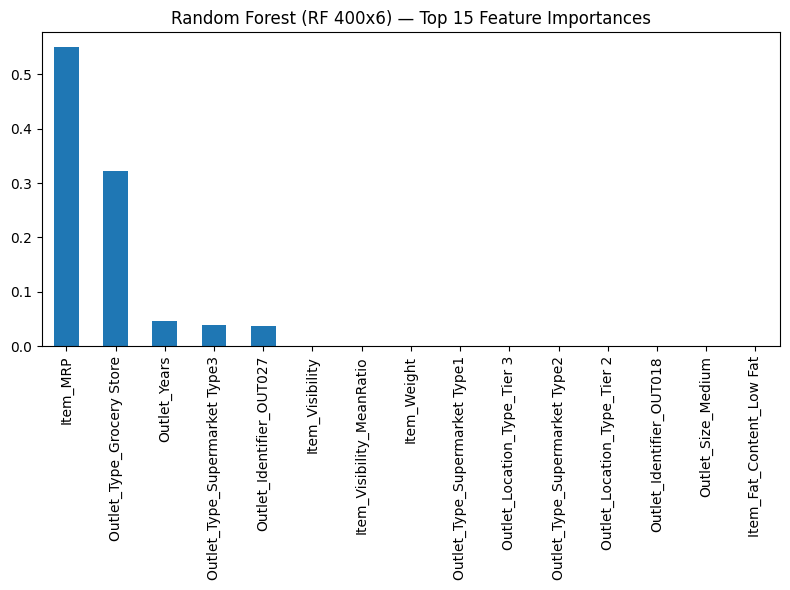

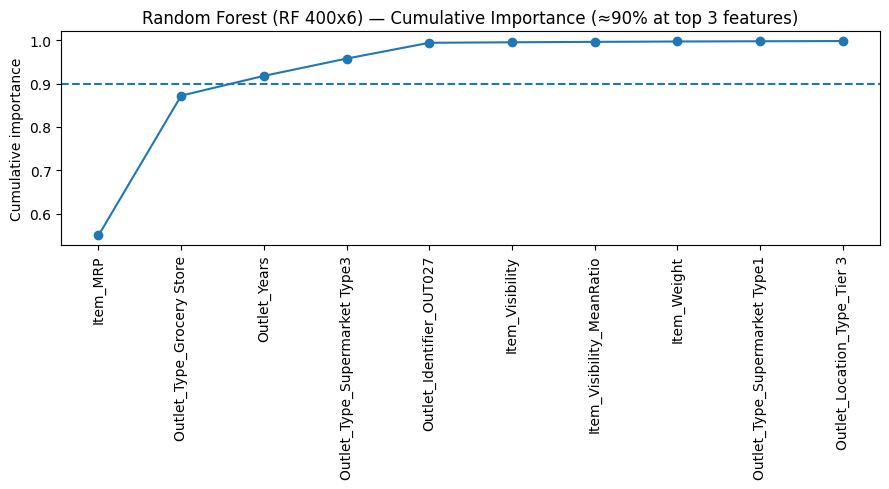

In [ ]:
# 10. RANDOM FOREST — stronger baselines + cumulative importance

from sklearn.ensemble import RandomForestRegressor

rf_models = {
    "RF 200x5": RandomForestRegressor(
        n_estimators=200, max_depth=5, min_samples_leaf=100,
        n_jobs=-1, random_state=RANDOM_STATE
    ),
    "RF 400x6": RandomForestRegressor(
        n_estimators=400, max_depth=6, min_samples_leaf=100,
        n_jobs=-1, random_state=RANDOM_STATE
    ),
    # Upgraded variants:
    "RF 1000x6 sqrt": RandomForestRegressor(
        n_estimators=1000, max_depth=6, min_samples_leaf=100,
        max_features="sqrt",  # adds tree diversity
        n_jobs=-1, random_state=RANDOM_STATE
    ),
    "RF 600x6 sqrt": RandomForestRegressor(
        n_estimators=600, max_depth=6, min_samples_leaf=100,
        max_features="sqrt",
        n_jobs=-1, random_state=RANDOM_STATE
    ),
}

# Cross-validate each candidate and keep the winner
rf_cv = {}
best_name, best_score = None, np.inf
for name, model in rf_models.items():
    m, s, mn, mx = cv_rmse(model, X, y)
    rf_cv[name] = (m, s, mn, mx)
    print(f"{name} RMSE mean={m:.1f} std={s:.1f} min={mn:.1f} max={mx:.1f}")
    if m < best_score:
        best_score, best_name = m, name

print(f"\nSelected RF: {best_name} (CV RMSE ≈ {best_score:.1f})")
best_rf = rf_models[best_name]
best_rf.fit(X, y)

# (A) Top feature importances (bar)
imp = pd.Series(best_rf.feature_importances_, index=X.columns)
imp_sorted = imp.sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_sorted.head(15).plot(kind="bar", title=f"Random Forest ({best_name}) — Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# (B) Cumulative importance (show where ~90% is reached)
cum = imp_sorted.cumsum()
cum_norm = cum / cum.iloc[-1]
k90 = int(np.searchsorted(cum_norm.values, 0.90)) + 1
show_k = max(10, k90)  # plot at least 10 for readability

plt.figure(figsize=(9, 5))
plt.plot(range(1, show_k + 1), cum_norm.iloc[:show_k].values, marker="o")
plt.axhline(0.90, linestyle="--")
plt.xticks(range(1, show_k + 1), imp_sorted.index[:show_k], rotation=90)
plt.ylabel("Cumulative importance")
plt.title(f"Random Forest ({best_name}) — Cumulative Importance (≈90% at top {k90} features)")
plt.tight_layout()
plt.show()

In [ ]:
# 11. FINAL PREDICTION + EXPORT

final_model = best_rf
final_model.fit(X, y)
pred = final_model.predict(X_test)



---



# **Next Improvements**



Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best GBR params: {'learning_rate': 0.03, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
GBR RMSE mean=1086.9


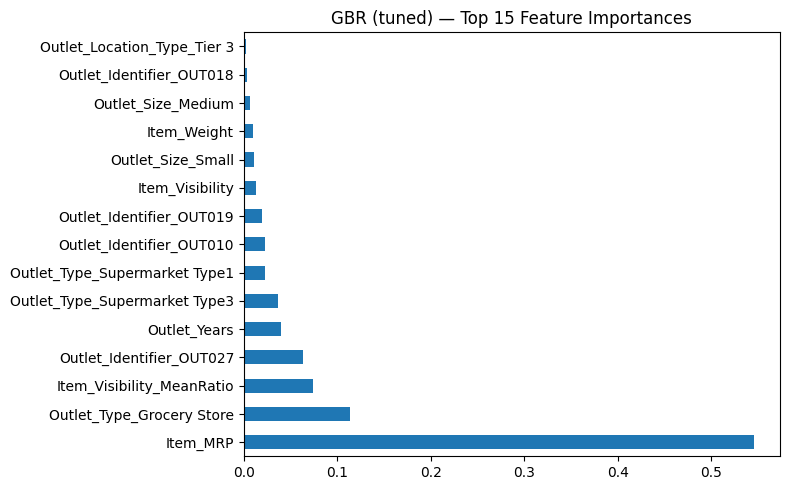

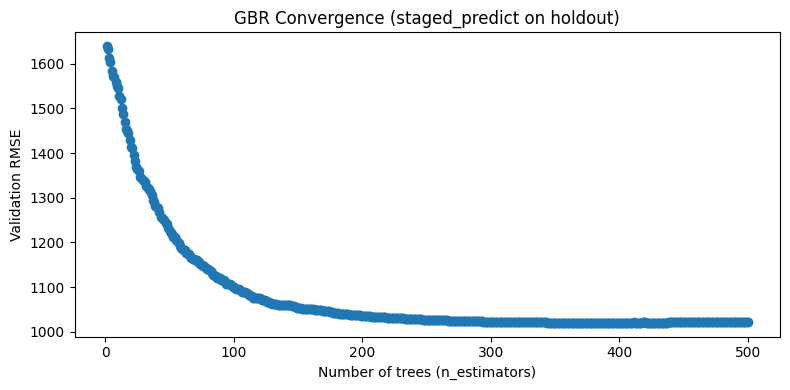

In [ ]:
# 12. GRADIENT BOOSTING REGRESSOR (GBR) — tuned + convergence plot

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# (A) Small, focused grid to smooth learning & add regularization
gbr_base = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbr_grid = {
    "n_estimators":  [300, 500],
    "learning_rate": [0.05, 0.03],
    "max_depth":     [3, 4],
    "subsample":     [1.0, 0.8],   # stochastic GB for regularization
    "max_features":  [None, "sqrt"]
}

gbr_search = GridSearchCV(
    gbr_base,
    param_grid=gbr_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)
gbr_search.fit(X, y)

best_gbr = gbr_search.best_estimator_
rmse_gbr_mean = float(-gbr_search.best_score_)
print("Best GBR params:", gbr_search.best_params_)
print(f"GBR RMSE mean={rmse_gbr_mean:.1f}")

# (B) Fit best GBR on full training, make test predictions for later comparison
best_gbr.fit(X, y)
pred_gbr = best_gbr.predict(X_test)

# (C) Feature importances (top 15)
imp_gbr = pd.Series(best_gbr.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
imp_gbr.head(15).plot(kind="barh", title="GBR (tuned) — Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# (D) Convergence curve (staged RMSE on a holdout split) — presentation-friendly
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
gbr_for_curve = gbr_search.best_estimator_
gbr_for_curve.fit(X_tr, y_tr)

rmse_path = []
for y_hat in gbr_for_curve.staged_predict(X_va):
    rmse_path.append(np.sqrt(mean_squared_error(y_va, y_hat)))

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(rmse_path)+1), rmse_path, marker="o")
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Validation RMSE")
plt.title("GBR Convergence (staged_predict on holdout)")
plt.tight_layout()
plt.show()

XGB (base) CV RMSE mean=1102.1 std=34.2 min=1044.1 max=1137.7
Best iteration (early stop): 166
Validation RMSE at best iter: 1018.4230859262241


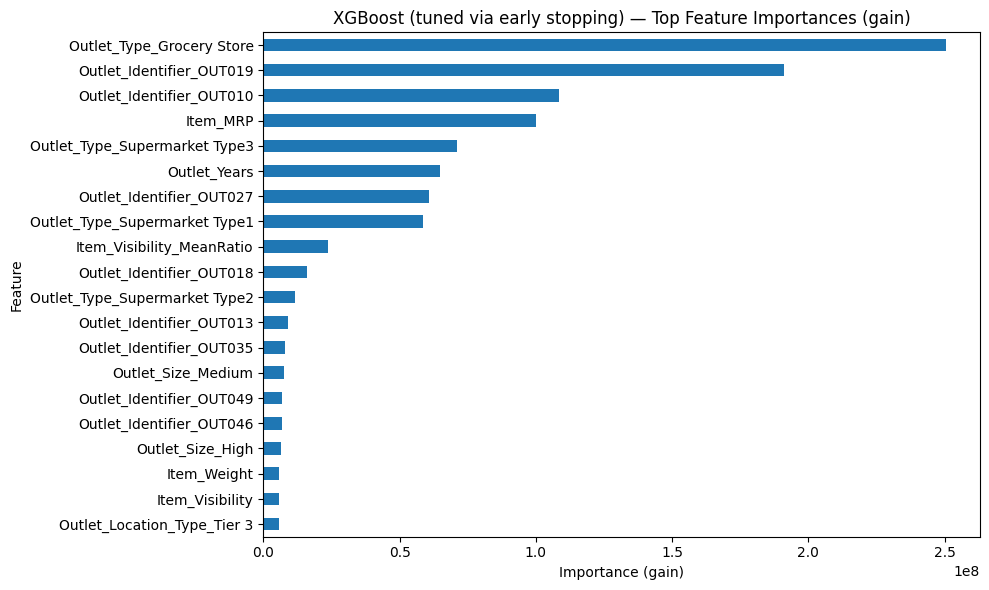

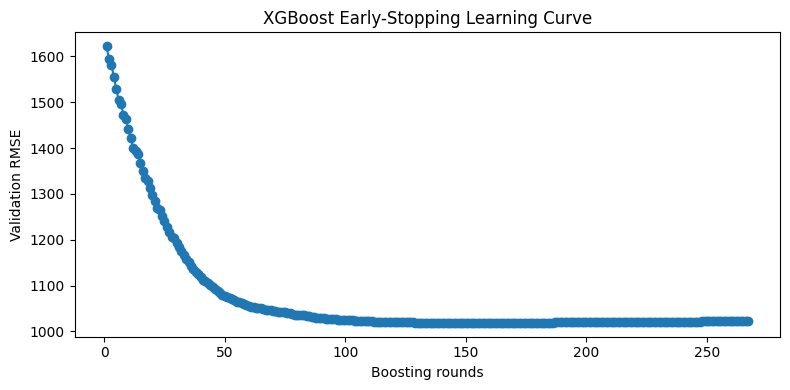

In [ ]:
# 13. XGBOOST — version-proof (early stopping via xgb.train) + visuals

try:
    import xgboost as xgb
    from xgboost import XGBRegressor, DMatrix, train as xgb_train
    from sklearn.model_selection import train_test_split

    # Cast to float32 for speed
    X32, X_test32 = X.astype("float32"), X_test.astype("float32")

    # ----- A) CV with sklearn wrapper (for apples-to-apples RMSE) -----
    xgb_base = XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.7,
        min_child_weight=5,
        reg_lambda=2.0,
        reg_alpha=0.1,
        gamma=0.1,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        objective="reg:squarederror",
        eval_metric="rmse"
    )
    rmse_xgb_mean, rmse_xgb_std, rmse_xgb_min, rmse_xgb_max = cv_rmse(xgb_base, X32, y)
    print(f"XGB (base) CV RMSE mean={rmse_xgb_mean:.1f} std={rmse_xgb_std:.1f} "
          f"min={rmse_xgb_min:.1f} max={rmse_xgb_max:.1f}")

    # ----- B) Early stopping using low-level API (works in old versions) -----
    from xgboost import DMatrix, train as xgb_train

    X_tr, X_va, y_tr, y_va = train_test_split(X32, y, test_size=0.2, random_state=RANDOM_STATE)

    feature_names = X.columns.tolist()
    dtrain = DMatrix(X_tr, label=y_tr, feature_names=feature_names)
    dvalid = DMatrix(X_va, label=y_va, feature_names=feature_names)
    dtest  = DMatrix(X_test32,        feature_names=feature_names)

    params = {
        "eta": 0.03,
        "max_depth": 4,
        "subsample": 0.8,
        "colsample_bytree": 0.7,
        "min_child_weight": 5,
        "lambda": 2.0,         # reg_lambda
        "alpha": 0.1,          # reg_alpha
        "gamma": 0.1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "seed": RANDOM_STATE
    }

    watchlist = [(dtrain, "train"), (dvalid, "valid")]
    evals_result = {}  # <-- capture eval history here

    bst = xgb_train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=watchlist,
        early_stopping_rounds=100,
        evals_result=evals_result,   # <-- fill this dict
        verbose_eval=False
    )

    best_iter = getattr(bst, "best_iteration", None)
    best_score = getattr(bst, "best_score", float("nan"))
    print(f"Best iteration (early stop): {best_iter}")
    print(f"Validation RMSE at best iter: {best_score}")

    # ----- C) Predict test using best_ntree_limit if available -----
    ntree_limit = getattr(bst, "best_ntree_limit", 0)
    pred_xgb = bst.predict(dtest, ntree_limit=ntree_limit) if ntree_limit else bst.predict(dtest)

    # ----- D) Feature importances (gain) -----
    gain_dict = bst.get_score(importance_type="gain")
    imp_series = pd.Series({f: gain_dict.get(f, 0.0) for f in feature_names}).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    imp_series.head(20).sort_values().plot(kind="barh")
    plt.title("XGBoost (tuned via early stopping) — Top Feature Importances (gain)")
    plt.xlabel("Importance (gain)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # ----- E) Learning curve from evals_result dict (version-safe) -----
    if "valid" in evals_result and "rmse" in evals_result["valid"]:
        rmse_curve = evals_result["valid"]["rmse"]
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(rmse_curve) + 1), rmse_curve, marker="o")
        plt.xlabel("Boosting rounds")
        plt.ylabel("Validation RMSE")
        plt.title("XGBoost Early-Stopping Learning Curve")
        plt.tight_layout()
        plt.show()
    else:
        print("No valid rmse curve available for plotting (older XGB evals_result).")

except Exception as e:
    print("XGBoost not available (install with: pip install xgboost). Skipping.")
    rmse_xgb_mean, pred_xgb = None, None
    print("Error details:", e)

[Log]    RF CV RMSE mean=1119.7 std=42.6
[YJ]     RF CV RMSE mean=1097.5 std=42.2
[BoxCox] RF CV RMSE mean=1097.4 std=42.2


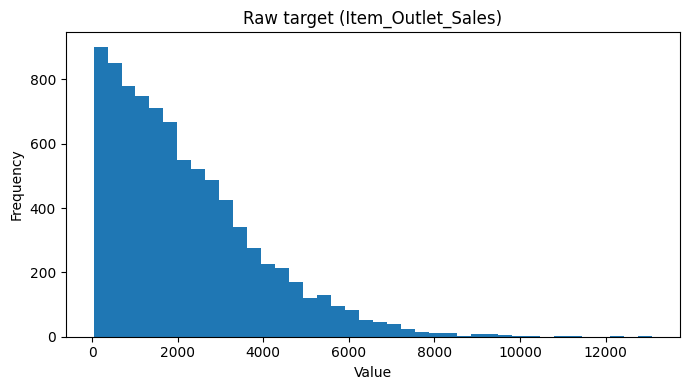

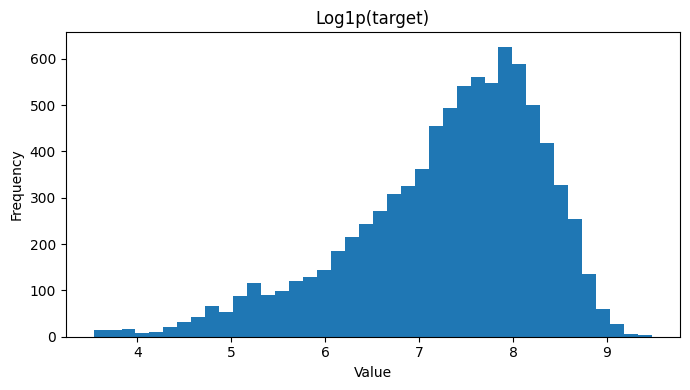

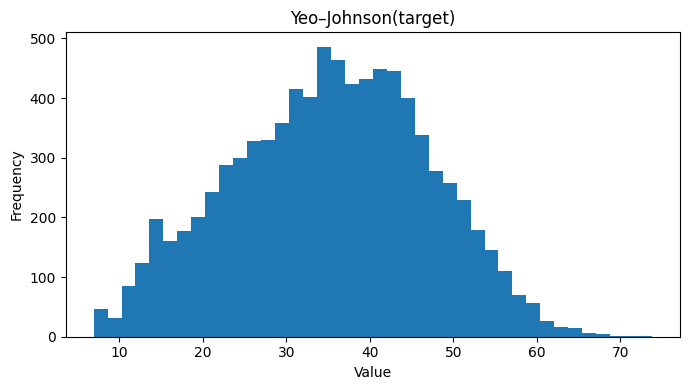

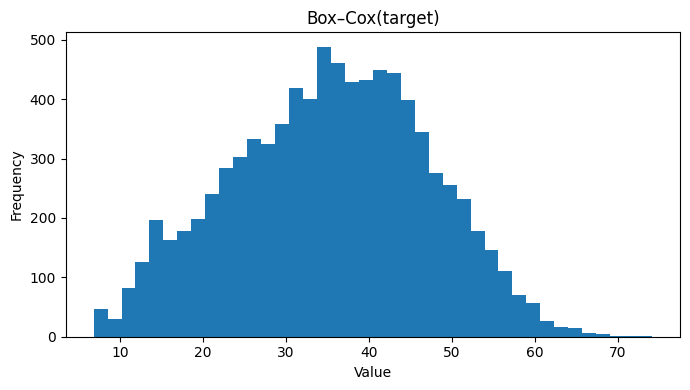


=== Target Transform Comparison (RF) ===


,Transform,CV_RMSE_Mean,CV_RMSE_Std
0,Box-Cox,1097.446461,42.200385
1,Yeo-Johnson,1097.458248,42.197688
2,Log1p,1119.683779,42.575845


Best transform here: Box-Cox (CV RMSE ≈ 1097.4)


In [ ]:
# 14. LOG-FAMILY TARGET TRANSFORMS (RF) — Log vs Yeo–Johnson vs Box–Cox + histograms

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# (A) Helper: evaluate a transform safely with CV (fit transform within each fold)
def cv_rmse_with_target_transform(model, X, y, transform_fit, transform_apply, inverse_apply, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # fit transform on training targets only (no leakage)
        t = transform_fit(y_tr)
        y_tr_t = transform_apply(t, y_tr)

        # train and evaluate
        model.fit(X_tr, y_tr_t)
        y_pred_t = model.predict(X_va)
        y_pred = inverse_apply(t, y_pred_t)

        rmse = np.sqrt(mean_squared_error(y_va, y_pred))
        rmses.append(rmse)
    return float(np.mean(rmses)), float(np.std(rmses))

# (B) Plot helpers (separate figures to keep it presentation-friendly)
def plot_hist(values, title, bins=40):
    plt.figure(figsize=(7,4))
    plt.hist(values, bins=bins)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# (C) Base RF config (same spirit as before)
rf_for_transforms = RandomForestRegressor(
    n_estimators=400,
    max_depth=6,
    min_samples_leaf=100,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

y_np = y.astype(float)

# 1) LOG TRANSFORM (log1p / expm1)
def log_fit(y_tr):
    # no parameters to learn; return None
    return None

def log_apply(_, y_arr):
    return np.log1p(y_arr)

def log_inverse(_, y_arr_t):
    return np.expm1(y_arr_t)

rmse_logrf_mean, rmse_logrf_std = cv_rmse_with_target_transform(
    rf_for_transforms, X, y_np, log_fit, log_apply, log_inverse, folds=5
)
print(f"[Log]    RF CV RMSE mean={rmse_logrf_mean:.1f} std={rmse_logrf_std:.1f}")

# 2) YEO–JOHNSON (PowerTransformer; works with non-positive too)
def yj_fit(y_tr):
    pt = PowerTransformer(method="yeo-johnson", standardize=False)
    pt.fit(y_tr.reshape(-1,1))
    return pt

def yj_apply(pt, y_arr):
    return pt.transform(y_arr.reshape(-1,1)).ravel()

def yj_inverse(pt, y_arr_t):
    return pt.inverse_transform(np.asarray(y_arr_t).reshape(-1,1)).ravel()

rmse_yjrf_mean, rmse_yjrf_std = cv_rmse_with_target_transform(
    rf_for_transforms, X, y_np, yj_fit, yj_apply, yj_inverse, folds=5
)
print(f"[YJ]     RF CV RMSE mean={rmse_yjrf_mean:.1f} std={rmse_yjrf_std:.1f}")

# 3) BOX–COX (requires strictly positive y; our sales are >0)
def bc_fit(y_tr):
    # estimate lambda on training fold only (no leakage)
    # returning the MLE lambda is enough since transform is monotonic
    y_tr = y_tr.copy()
    lmbda = boxcox(y_tr)[1]  # boxcox returns (transformed, lambda)
    return lmbda

def bc_apply(lmbda, y_arr):
    return boxcox(y_arr, lmbda=lmbda)

def bc_inverse(lmbda, y_arr_t):
    return inv_boxcox(y_arr_t, lmbda)

rmse_bcrf_mean, rmse_bcrf_std = cv_rmse_with_target_transform(
    rf_for_transforms, X, y_np, bc_fit, bc_apply, bc_inverse, folds=5
)
print(f"[BoxCox] RF CV RMSE mean={rmse_bcrf_mean:.1f} std={rmse_bcrf_std:.1f}")

# (D) Visualize raw vs transformed distributions (separate figures)
plot_hist(y_np,                "Raw target (Item_Outlet_Sales)")
plot_hist(np.log1p(y_np),      "Log1p(target)")
# For YJ and BC, fit once on full y for display-only (not for CV)
pt_display = PowerTransformer(method="yeo-johnson", standardize=False).fit(y_np.reshape(-1,1))
plot_hist(pt_display.transform(y_np.reshape(-1,1)).ravel(), "Yeo–Johnson(target)")
lam_display = boxcox(y_np)[1]
plot_hist(boxcox(y_np, lmbda=lam_display), "Box–Cox(target)")

# (E) Train full models for test predictions (use the three transforms)
#     Keep your original variable names for compatibility with later cells.
# LOG
rf_log = rf_for_transforms
rf_log.fit(X, np.log1p(y_np))
pred_test_log = np.expm1(rf_log.predict(X_test))

# YEO–JOHNSON
pt_full = PowerTransformer(method="yeo-johnson", standardize=False).fit(y_np.reshape(-1,1))
rf_yj = RandomForestRegressor(
    n_estimators=400, max_depth=6, min_samples_leaf=100,
    n_jobs=-1, random_state=RANDOM_STATE
)
rf_yj.fit(X, pt_full.transform(y_np.reshape(-1,1)).ravel())
pred_test_yj = pt_full.inverse_transform(rf_yj.predict(X_test).reshape(-1,1)).ravel()

# BOX–COX
lam_full = boxcox(y_np)[1]
rf_bc = RandomForestRegressor(
    n_estimators=400, max_depth=6, min_samples_leaf=100,
    n_jobs=-1, random_state=RANDOM_STATE
)
rf_bc.fit(X, boxcox(y_np, lmbda=lam_full))
pred_test_bc = inv_boxcox(rf_bc.predict(X_test), lam_full)

# (F) Compact summary (nice for video overlay)
summary_14 = pd.DataFrame({
    "Transform": ["Log1p", "Yeo-Johnson", "Box-Cox"],
    "CV_RMSE_Mean": [rmse_logrf_mean, rmse_yjrf_mean, rmse_bcrf_mean],
    "CV_RMSE_Std":  [rmse_logrf_std,  rmse_yjrf_std,  rmse_bcrf_std]
}).sort_values("CV_RMSE_Mean", ascending=True).reset_index(drop=True)

print("\n=== Target Transform Comparison (RF) ===")
display(summary_14)

# (G) (Optional) Annotate takeaway for your talk track:
best_row = summary_14.iloc[0]
print(f"Best transform here: {best_row.Transform} (CV RMSE ≈ {best_row.CV_RMSE_Mean:.1f})")

Baseline RF (400x6, leaf=100) 5-fold RMSE: 1084.5918 ± 38.4424

Running RandomizedSearchCV on RandomForest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best RF params (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 40, 'max_features': None, 'max_depth': 7, 'bootstrap': True}
Best RF 5-fold CV RMSE: 1082.6276
Saved RandomizedSearchCV results -> /content/rf_random_search_results.csv

Top 10 RandomizedSearchCV trials (by CV RMSE):


,rank_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features,param_bootstrap,CV_RMSE
0,1,400,7,40,5,None,True,1082.627636
1,2,550,6,60,10,0.8,True,1083.309681
2,3,600,5,30,20,0.8,True,1084.314065
3,4,550,5,30,10,0.8,True,1084.350715
4,5,700,6,20,10,0.6,True,1085.173787
5,6,500,8,60,2,0.6,True,1085.322663
6,7,600,8,20,2,None,True,1086.704249
7,8,600,6,20,5,0.6,False,1088.611000
8,9,500,5,60,2,0.8,False,1088.650718
9,10,350,6,60,5,0.6,False,1088.828192


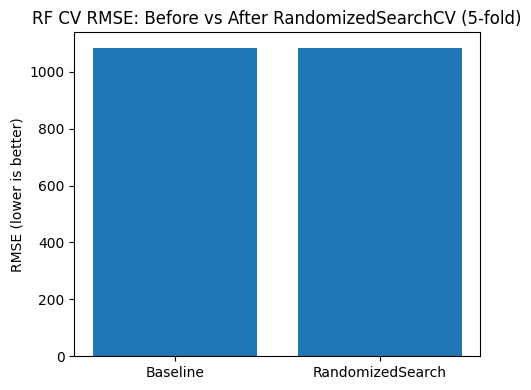

In [ ]:
# 15. RANDOMIZED HYPERPARAMETER SEARCH (RANDOM FOREST) — expanded + 5-fold + results export

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# (A) Baseline RF for before/after comparison (same spirit as earlier)
baseline_rf = RandomForestRegressor(
    n_estimators=400, max_depth=6, min_samples_leaf=100,
    n_jobs=-1, random_state=RANDOM_STATE
)
baseline_mean, baseline_std, _, _ = cv_rmse(baseline_rf, X, y, folds=5)
print(f"Baseline RF (400x6, leaf=100) 5-fold RMSE: {baseline_mean:.4f} ± {baseline_std:.4f}")

# (B) Expanded search space (diversity + overfit control)
param_dist = {
    "n_estimators":     [350, 400, 450, 500, 550, 600, 700],
    "max_depth":        [5, 6, 7, 8],
    "min_samples_leaf": [20, 30, 40, 60, 100],
    "min_samples_split":[2, 5, 10, 20],
    "max_features":     [None, "sqrt", 0.6, 0.8],
    "bootstrap":        [True, False],
}

rf_base = RandomForestRegressor(
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=25,                         # efficient exploration
    scoring="neg_root_mean_squared_error",
    cv=5,                              # 5-fold for robustness
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

print("\nRunning RandomizedSearchCV on RandomForest...")
rf_search.fit(X, y)

print("\nBest RF params (RandomizedSearchCV):", rf_search.best_params_)
rmse_rf_tuned_mean = float(-rf_search.best_score_)
print(f"Best RF 5-fold CV RMSE: {rmse_rf_tuned_mean:.4f}")

# (C) Train final tuned RF on full training and keep predictions for cell 18
best_rf_tuned = rf_search.best_estimator_
best_rf_tuned.fit(X, y)
pred_tuned = best_rf_tuned.predict(X_test)

# Show top 10 tried configs (nice for video)
print("\nTop 10 RandomizedSearchCV trials (by CV RMSE):")
top10 = cvres_sorted.head(10)[
    ["rank_test_score", "mean_test_score", "param_n_estimators",
     "param_max_depth", "param_min_samples_leaf", "param_min_samples_split",
     "param_max_features", "param_bootstrap"]
].copy()
top10["CV_RMSE"] = -top10["mean_test_score"]
display(top10.drop(columns=["mean_test_score"]))

# (E) Mini before/after bar for the presentation
plt.figure(figsize=(5, 4))
plt.bar(["Baseline", "RandomizedSearch"], [baseline_mean, rmse_rf_tuned_mean])
plt.title("RF CV RMSE: Before vs After RandomizedSearchCV (5-fold)")
plt.ylabel("RMSE (lower is better)")
plt.tight_layout()
plt.show()

Running GridSearchCV with params: {'n_estimators': [300, 400, 500], 'max_depth': [6, 7, 8], 'min_samples_leaf': [30, 40, 50], 'max_features': [None, 'sqrt', 0.8, 0.6]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF (grid) params: {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 40, 'n_estimators': 300}
Best RF (grid) 5-fold CV RMSE: 1082.1273

Top 10 GridSearchCV trials (by CV RMSE):


,rank_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_max_features,CV_RMSE
0,1,300,6,40,None,1082.127319
1,2,500,6,40,None,1082.199561
2,3,400,6,40,None,1082.218773
3,4,500,6,40,0.8,1082.269575
4,5,400,6,40,0.8,1082.341014
5,6,300,6,50,0.8,1082.358308
6,7,500,6,50,0.8,1082.365917
7,8,400,6,50,0.8,1082.393632
8,9,300,6,50,None,1082.419289
9,10,300,6,40,0.8,1082.451622


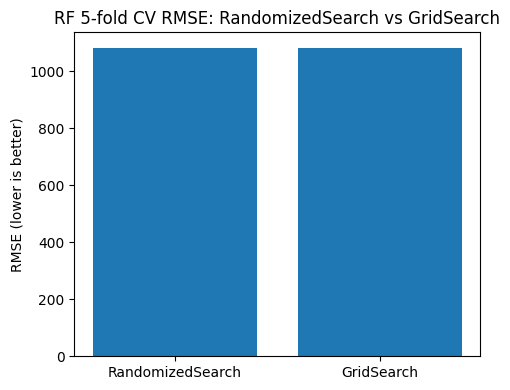

In [ ]:
# 16. GRID SEARCH FINE-TUNING (RANDOM FOREST) — fixed max_features list

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Seed around RandomizedSearch best (if available)
try:
    base_best = rf_search.best_params_
    best_n  = int(base_best.get("n_estimators", 500))
    best_d  = int(base_best.get("max_depth", 6))
    best_l  = int(base_best.get("min_samples_leaf", 30))
    best_mf = base_best.get("max_features", None)
except Exception:
    best_n, best_d, best_l, best_mf = 500, 6, 30, None

# Tight grids
n_list = sorted({max(100, best_n - 100), best_n, best_n + 100})
d_list = sorted({max(3, best_d - 1), best_d, best_d + 1})
l_list = sorted({max(5, best_l - 10), best_l, best_l + 10})

# ---- FIX: build max_features list without sorting mixed types ----
allowed_mf = [None, "sqrt", 0.8, 0.6]
mf_candidates = [best_mf] + allowed_mf
mf_list = []
for v in mf_candidates:
    if v in (None, "sqrt", 0.8, 0.6) and v not in mf_list:
        mf_list.append(v)
# ---------------------------------------------------------------

grid_params = {
    "n_estimators": n_list,
    "max_depth": d_list,
    "min_samples_leaf": l_list,
    "max_features": mf_list
}

rf_base_grid = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

grid = GridSearchCV(
    estimator=rf_base_grid,
    param_grid=grid_params,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

print("Running GridSearchCV with params:", grid_params)
grid.fit(X, y)
print("Best RF (grid) params:", grid.best_params_)

rmse_rf_grid_mean = float(-grid.best_score_)
print(f"Best RF (grid) 5-fold CV RMSE: {rmse_rf_grid_mean:.4f}")

best_rf_grid = grid.best_estimator_
best_rf_grid.fit(X, y)
pred_grid = best_rf_grid.predict(X_test)

# Show top trials
print("\nTop 10 GridSearchCV trials (by CV RMSE):")
top10_grid = gridres.head(10)[
    ["rank_test_score", "mean_test_score", "param_n_estimators",
     "param_max_depth", "param_min_samples_leaf", "param_max_features"]
].copy()
top10_grid["CV_RMSE"] = -top10_grid["mean_test_score"]
display(top10_grid.drop(columns=["mean_test_score"]))

# Side-by-side comparison with RandomizedSearch (if available)
try:
    rmse_rf_tuned_mean  # from cell 15
    plt.figure(figsize=(5, 4))
    plt.bar(["RandomizedSearch", "GridSearch"], [rmse_rf_tuned_mean, rmse_rf_grid_mean])
    plt.title("RF 5-fold CV RMSE: RandomizedSearch vs GridSearch")
    plt.ylabel("RMSE (lower is better)")
    plt.tight_layout()
    plt.show()
except NameError:
    print("RandomizedSearch results not found; skipping comparison plot.")

RF + Interactions RMSE mean=1080.1 std=36.3 min=1017.6 max=1118.5

Permutation importance (mean) for new features (> 0.01):
  None exceeded 0.01 on the holdout split.


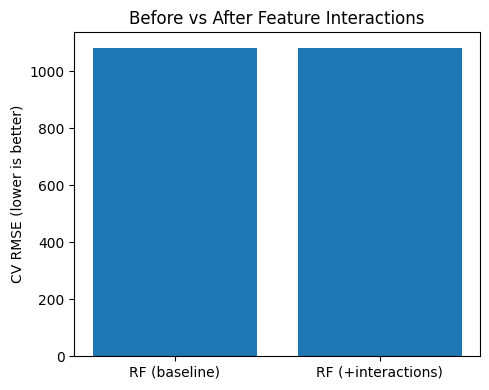

In [ ]:
# 17. SIMPLE FEATURE INTERACTIONS + RATIO (RF) — with permutation importance & before/after chart

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# (A) Build interaction features
X_int = X.copy()

# Interactions from before
if "Item_MRP" in X_int.columns and "Outlet_Years" in X_int.columns:
    X_int["MRP_x_Years"] = X_int["Item_MRP"] * X_int["Outlet_Years"]

if "Item_Visibility_MeanRatio" in X_int.columns and "Outlet_Years" in X_int.columns:
    X_int["VisRatio_x_Years"] = X_int["Item_Visibility_MeanRatio"] * X_int["Outlet_Years"]

# NEW: normalized ratio feature
if "Item_Weight" in X_int.columns and "Item_MRP" in X_int.columns:
    eps = 1e-6
    X_int["Weight_to_MRP"] = X_int["Item_Weight"] / (X_int["Item_MRP"] + eps)

# Prepare matching test matrix
X_test_int = X_test.copy()
if "Item_MRP" in X_test_int.columns and "Outlet_Years" in X_test_int.columns:
    X_test_int["MRP_x_Years"] = X_test_int["Item_MRP"] * X_test_int["Outlet_Years"]

if "Item_Visibility_MeanRatio" in X_test_int.columns and "Outlet_Years" in X_test_int.columns:
    X_test_int["VisRatio_x_Years"] = X_test_int["Item_Visibility_MeanRatio"] * X_test_int["Outlet_Years"]

if "Item_Weight" in X_test_int.columns and "Item_MRP" in X_test_int.columns:
    eps = 1e-6
    X_test_int["Weight_to_MRP"] = X_test_int["Item_Weight"] / (X_test_int["Item_MRP"] + eps)

# (B) Choose a fair RF config (use your tuned grid if available; else fallback)
try:
    rf_int = best_rf_grid.__class__(**best_rf_grid.get_params())
except Exception:
    rf_int = RandomForestRegressor(
        n_estimators=400, max_depth=6, min_samples_leaf=100,
        n_jobs=-1, random_state=RANDOM_STATE
    )

# (C) Baseline RMSE on original features (for before/after bar)
try:
    baseline_rmse_rf = rmse_rf_grid_mean  # from Cell 16
except NameError:
    # compute quickly with same rf config on original X
    m_base, s_base, _, _ = cv_rmse(rf_int, X, y)
    baseline_rmse_rf = m_base

# (D) CV on interaction features
rmse_rf_int_mean, rmse_rf_int_std, rmse_rf_int_min, rmse_rf_int_max = cv_rmse(rf_int, X_int, y)
print(f"RF + Interactions RMSE mean={rmse_rf_int_mean:.1f} std={rmse_rf_int_std:.1f} "
      f"min={rmse_rf_int_min:.1f} max={rmse_rf_int_max:.1f}")

# (E) Fit on full data and predict test
rf_int.fit(X_int, y)
pred_int = rf_int.predict(X_test_int)

# (F) Permutation importance on a holdout split (to gauge new features' utility)
X_tr, X_va, y_tr, y_va = train_test_split(X_int, y, test_size=0.2, random_state=RANDOM_STATE)
rf_hold = RandomForestRegressor(**rf_int.get_params())
rf_hold.fit(X_tr, y_tr)
perm = permutation_importance(rf_hold, X_va, y_va, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

pi = pd.Series(perm.importances_mean, index=X_int.columns).sort_values(ascending=False)

new_feats = [f for f in ["MRP_x_Years", "VisRatio_x_Years", "Weight_to_MRP"] if f in X_int.columns]
sig_new = {f: float(pi.get(f, 0.0)) for f in new_feats if pi.get(f, 0.0) > 0.01}

print("\nPermutation importance (mean) for new features (> 0.01):")
if sig_new:
    for k, v in sig_new.items():
        print(f"  {k}: {v:.4f}")
else:
    print("  None exceeded 0.01 on the holdout split.")

# (G) Before/after RMSE bar chart (presentation-friendly)
plt.figure(figsize=(5,4))
plt.bar(["RF (baseline)", "RF (+interactions)"], [baseline_rmse_rf, rmse_rf_int_mean])
plt.ylabel("CV RMSE (lower is better)")
plt.title("Before vs After Feature Interactions")
plt.tight_layout()
plt.show()

Best model: RF_Interactions with CV RMSE ≈ 1080.1
Saved -> /content/phuong_minh_nguyen.csv
=== Model Performance Summary ===


,Model,RMSE,Params,Notes
0,RF_Interactions,1080.105695,"RF tuned cfg + [MRP×Years, VisRatio×Years, Wei...",simple engineered interactions
1,RF_Grid,1082.127319,"{'max_depth': 6, 'max_features': None, 'min_sa...",GridSearchCV fine-tune
2,RF_Tuned,1082.627636,"{'n_estimators': 400, 'min_samples_split': 5, ...",RandomizedSearchCV best
3,GradientBoosting,1086.880571,"{'learning_rate': 0.03, 'max_depth': 3, 'max_f...",tuned grid
4,XGBoost,1102.115580,"eta=0.03, max_depth=4, subsample=0.8, colsampl...",hist + early stopping (low-level)
5,LogRF,1119.683779,"RF(400x6, leaf=100) on log1p(y)",variance-stabilized target


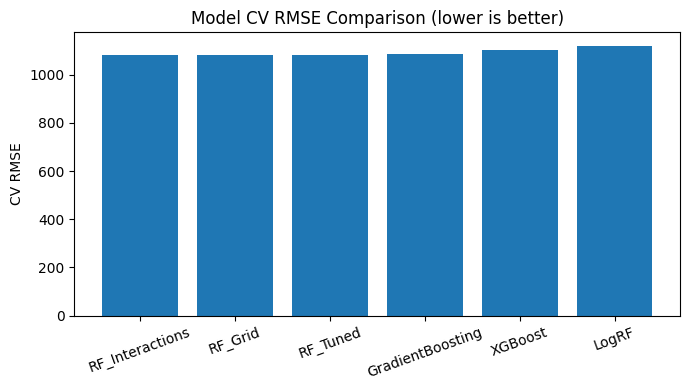

✅ Final submission shape: (5681, 3)
✅ Columns: ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']

Preview:


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1645.992853
1,FDW14,OUT017,1363.380192
2,NCN55,OUT010,599.731597
3,FDQ58,OUT017,2502.202328
4,FDY38,OUT027,6230.882023


In [ ]:
# 18. PICK A WINNER & SAVE — guard rails + RMSE bar + summary export

from datetime import datetime

def _safe_add(cdict, name, rmse, preds, params, notes, expected_len):
    """Add a candidate only if rmse is numeric and preds length matches test set."""
    try:
        if rmse is None or preds is None:
            return
        rmse_f = float(rmse)
        preds = np.asarray(preds, dtype=float)
        if len(preds) != expected_len or np.isnan(rmse_f):
            return
        cdict[name] = {"rmse": rmse_f, "pred": preds, "params": params, "notes": notes}
    except Exception:
        pass

n_test = len(X_test)

candidates = {}

# GBR (cell 12)
try:
    gbr_params = gbr_search.best_params_ if 'gbr_search' in globals() else "GBR tuned"
    _safe_add(candidates, "GradientBoosting", rmse_gbr_mean, pred_gbr, str(gbr_params), "tuned grid", n_test)
except Exception:
    pass

# XGBoost (cell 13)
try:
    _safe_add(candidates, "XGBoost", rmse_xgb_mean, pred_xgb,
              "eta=0.03, max_depth=4, subsample=0.8, colsample_bytree=0.7 (+ES)",
              "hist + early stopping (low-level)", n_test)
except Exception:
    pass

# Log-Transformed RF (cell 14)
try:
    _safe_add(candidates, "LogRF", rmse_logrf_mean, pred_test_log,
              "RF(400x6, leaf=100) on log1p(y)", "variance-stabilized target", n_test)
except Exception:
    pass

# RandomizedSearch RF (cell 15)
try:
    _safe_add(candidates, "RF_Tuned", rmse_rf_tuned_mean, pred_tuned,
              str(rf_search.best_params_), "RandomizedSearchCV best", n_test)
except Exception:
    pass

# GridSearch RF (cell 16)
try:
    _safe_add(candidates, "RF_Grid", rmse_rf_grid_mean, pred_grid,
              str(grid.best_params_), "GridSearchCV fine-tune", n_test)
except Exception:
    pass

# Interactions RF (cell 17)
try:
    _safe_add(candidates, "RF_Interactions", rmse_rf_int_mean, pred_int,
              "RF tuned cfg + [MRP×Years, VisRatio×Years, Weight/MRP]", "simple engineered interactions", n_test)
except Exception:
    pass

if not candidates:
    raise RuntimeError("No candidate predictions found. Run cells 12–17 first.")

# Pick the winner (lowest CV RMSE)
best_name = min(candidates, key=lambda k: candidates[k]["rmse"])
best_rmse = candidates[best_name]["rmse"]
best_pred = candidates[best_name]["pred"]

print(f"Best model: {best_name} with CV RMSE ≈ {best_rmse:.1f}")

# Post-process predictions: clip negatives (sales can't be negative)
final_pred = np.clip(best_pred, 0, None)

# Build final submission with exact column order from sample
sub_best = sub.copy()
sub_best["Item_Outlet_Sales"] = final_pred
sub_best = sub_best[["Item_Identifier", "Outlet_Identifier", "Item_Outlet_Sales"]]

FINAL_PATH = "/content/phuong_minh_nguyen.csv"
sub_best.to_csv(FINAL_PATH, index=False)
print(f"Saved -> {FINAL_PATH}")

# ===== Results summary table =====
rows = []
for name, d in candidates.items():
    rows.append({
        "Model": name,
        "RMSE": d["rmse"],
        "Params": d["params"],
        "Notes": d["notes"],
    })
results_summary = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print("=== Model Performance Summary ===")
display(results_summary)

# ===== RMSE comparison bar chart =====
plt.figure(figsize=(7,4))
plt.bar(results_summary["Model"], results_summary["RMSE"])
plt.title("Model CV RMSE Comparison (lower is better)")
plt.ylabel("CV RMSE")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# ===== Final submission preview =====
final_df = pd.read_csv(FINAL_PATH)
print("✅ Final submission shape:", final_df.shape)
print("✅ Columns:", list(final_df.columns))
print("\nPreview:")
display(final_df.head())